<a href="https://colab.research.google.com/github/jpti89/Video-violence-detection/blob/main/Train_violence_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Violence detection model using Tensorflow Keras + MobileNetV2 model

Using the dataset from Kaggle https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset we managed to fine-tune and train a CNN model.

The architecture of the Full project is:
- Download the Dataset from Google Drive
- Extract image frames of every video standarizing every image at 128x128 px
- Separating the images in train and test sets
- Load the MobileNetV2
- Finetune the learning rates, epochs and batch size to get the best results
- Train the model
- Save weights and model
- Evaluate


The labels of each frame are mantained for the whole video. That means, if there's violence only in some frames of the video, the network learns from the whole video anyway. This could generate a problem with some incorrect predictions using videos from outside the traning dataset.

MobileNetV2 was choosen because it's lightweight, fast and easy to train model, accurate for our CNN clasification use case.

## Setup of the project

In [1]:
# Create paths if not exist
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

Linux-6.1.58+-x86_64-with-glibc2.35


In [2]:
# Use Google Colab TPU
import tensorflow as tf
tf.random.set_seed(805)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;
print("Tensorflow version " + tf.__version__)

/bin/bash: line 1: nvidia-smi: command not found
Tensorflow version 2.15.0


In [3]:
#Import Dataset from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Dataset Working dir

MyDrive = '/content/'

PROJECT_DIR = '../content/drive/MyDrive/Computer-vision/real-life-violence-situations'
!ls {PROJECT_DIR}

Real-Life-Violence-Dataset


## **Preprocessing**

In [5]:
!pip install imgaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.6 MB/s eta 0:00:00


### Function to get frames of videos

Standarize, affine and rotate image from each video


In [6]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

# 128x128 standarize image size, 3 channels
IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)

    import math
    rate = math.floor(vidcap.get(3))
    count = 0

    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()

        if success:
            # skipping frames to avoid duplications
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))

                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)

                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)

            count += 1
        else:
            break

    vidcap.release()

    return ImageFrames

In [7]:
# Assign the category to each frame extracted from the videos
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real-Life-Violence-Dataset'

X_original = []
y_original = []

CLASSES = ["NonViolence", "Violence"]

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:500])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
1000 Violence videos 
1000 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 350/350 [01:51<00:00,  3.13it/s]

CPU times: user 7min 20s, sys: 2min, total: 9min 21s
Wall time: 3min 10s


In [8]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

13943

In [9]:
# Split Train and test datasets
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [10]:
!pip install imutils

In [11]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
import keras
matplotlib.use("Agg")

from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Reshape, Permute, Flatten

import matplotlib.pyplot as plt

In [12]:
# Model Setup epochs and base model used
epochs = 15

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False,
                            input_tensor=input_tensor)

    headModel = baseModel.output
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu 

In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

#Fine tune the learning rates and batch size
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [14]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True,
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [15]:
#Training of the model
history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/15
2439/2440 [============================>.] - ETA: 0s - loss: 0.8281 - accuracy: 0.5552
Epoch 1: val_loss improved from inf to 0.69958, saving model to ModelWeights.h5
2440/2440 [==============================] - 85s 34ms/step - loss: 0.8281 - accuracy: 0.5552 - val_loss: 0.6996 - val_accuracy: 0.6091 - lr: 1.0000e-05
Epoch 2/15
2439/2440 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.6963
Epoch 2: val_loss improved from 0.69958 to 0.48331, saving model to ModelWeights.h5
2440/2440 [==============================] - 77s 32ms/step - loss: 0.5798 - accuracy: 0.6963 - val_loss: 0.4833 - val_accuracy: 0.7691 - lr: 1.8000e-05
Epoch 3/15
2440/2440 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8129
Epoch 3: val_loss improved from 0.48331 to 0.36200, saving model to ModelWeights.h5
2440/2440 [==============================] - 77s 32ms/step - loss: 0.4170 - accuracy: 0.8129 - val_loss: 0.3620 - val_accuracy: 0.8456 - 

In [16]:
%matplotlib inline

# Graphs and summary for evaluate the model performance

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i

def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  12
Accuracy on train: 0.938524603843689 	Loss on train: 0.17168425023555756
Accuracy on test: 0.9316279888153076 	Loss on test: 0.1785876452922821


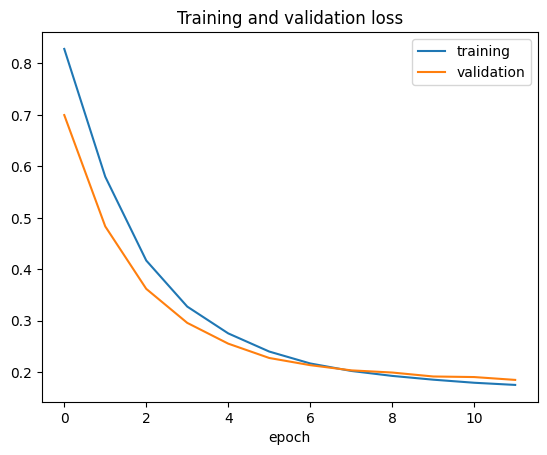

<Figure size 640x480 with 0 Axes>

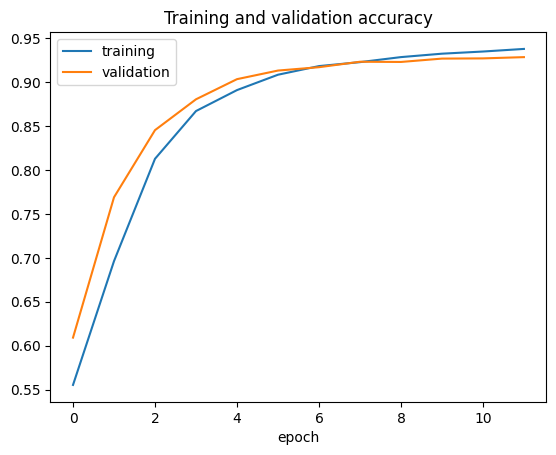

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [17]:
model_summary(model, history)

## **Evaluation on test set**

In [18]:
# evaluate the network with a Threshold of 0.5
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
131/131 [==============================] - 10s 70ms/step


> Correct Predictions: 3897
> Wrong Predictions: 286


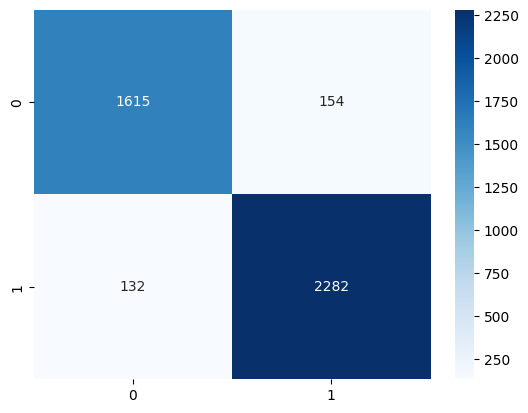

              precision    recall  f1-score   support

 NonViolence       0.92      0.91      0.92      1769
    Violence       0.94      0.95      0.94      2414

    accuracy                           0.93      4183
   macro avg       0.93      0.93      0.93      4183
weighted avg       0.93      0.93      0.93      4183



In [19]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = np.int32((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = np.int32((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds,
                           target_names=["NonViolence", "Violence"]))

In [23]:
 # Save model
 args_model = "model.h5"
 model.save(args_model)
 model = load_model('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Visual test of the accuracy of the model

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
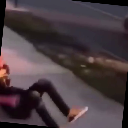

In [53]:
# Extract video frame and save image
from PIL import Image
image_file = video_to_frames('/content/drive/MyDrive/Computer-vision/real-life-violence-situations/Real-Life-Violence-Dataset/Violence/V_30.mp4')[0]
im = Image.fromarray(image_file)
im.save("inference.jpeg")

image_file

In [54]:
# Use the image just obtained and generate a prediction classifing ig it's Violence or not, with a Threshold of 0.5
import numpy as np
from keras.preprocessing import image

img_width, img_height = 128, 128
img = image.load_img("inference.jpeg", target_size = (img_width, img_height))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

if model.predict(img) > 0.5:
  print(model.predict(img), " Violence")
else:
  print(model.predict(img), " NonViolence")

1/1 [==============================] - 0s 33ms/step
[[0.39194608]]  NonViolence
